### Building a predictive model to identify the types of customers most likely to churn. 

In [402]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import boxcox

#display all the columns
pd.set_option('display.max_columns', None)

### Import data file

In [403]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [404]:
df.shape

(7043, 21)

In [405]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [407]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [408]:
# as customerId feature has all unique values we can drop it from the dataset as it is not contributing towards the prediction model
print(f"Count of unique values of customerId features is {len(df['customerID'].unique())} which is same as the total number of recors.")

df = df.drop(columns=['customerID'])

Count of unique values of customerId features is 7043 which is same as the total number of recors.


In [409]:
cat_ft = [feature for feature in df.columns if df[feature].dtype=='O']
num_ft = [feature for feature in df.columns if df[feature].dtype!='O']
print(f"Observations:\n\t1. Categorical features count: {len(cat_ft)}\n\t2. Numerical features count: {len(num_ft)}")

Observations:
	1. Categorical features count: 16
	2. Numerical features count: 4


#### Missing Values

In [410]:
df.isnull().sum()
# TotalCharges feature have 11 missing values

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [411]:
nan_ft = 'TotalCharges'
print(np.round((df[nan_ft].isnull().mean())*100, 3), ' % missing values.')

0.156  % missing values.


#### Numerical Variables and its Distribution

In [412]:
# we have 4 numerical variables
print(f"{num_ft}\nCount: {len(num_ft)}")

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Count: 4


In [413]:
df['SeniorCitizen'].unique()

# senior citizen is actually a categorical variable with unique values as [0,1] so we should remove it from num_ft and put it into cat_ft list
num_ft.remove('SeniorCitizen')
cat_ft.append('SeniorCitizen')

In [414]:
df[num_ft].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [415]:
# filtering discrete features

# we will filter out those features that has unique features count less than 25 as discrete feature
dis_ft = [feature for feature in num_ft if len(df[feature].unique()) < 50]
len(dis_ft)

# from the count we can see that all the numerical feature have unique value count more than 50 so they all must be continuous variables

0

In [416]:
# filtering continuous features

# as seen above all the numerical features are continuous
cont_ft = num_ft

Frequency Distributions:


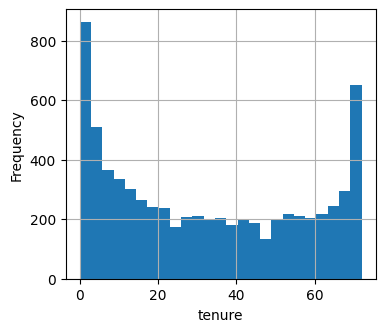

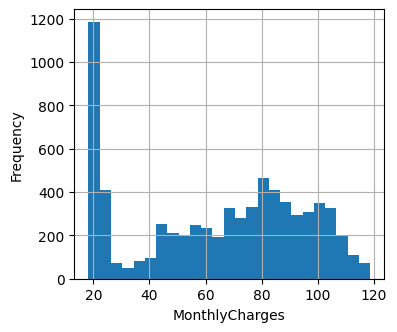

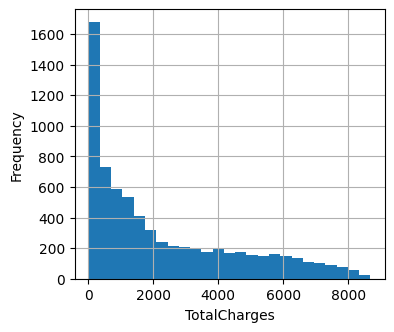

In [417]:
# From the above description of the numerical features we can see that the mean and the meadian of all the features are not having Guassian/Normal distribution

print("Frequency Distributions:")

for feature in cont_ft:
   plt.figure(figsize=(4, 3.5))
   df[feature].hist(bins=25)
   # plt.title(f'Frequency Distribution of {feature}')
   plt.xlabel(feature)
   plt.ylabel('Frequency')
   plt.show()

# we have to normalise them in Feature Engineering

#### Outliers

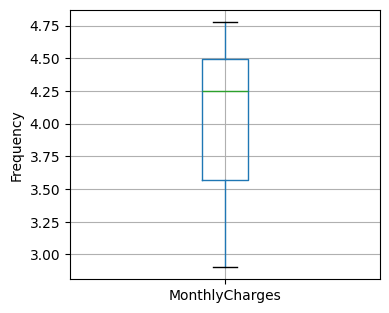

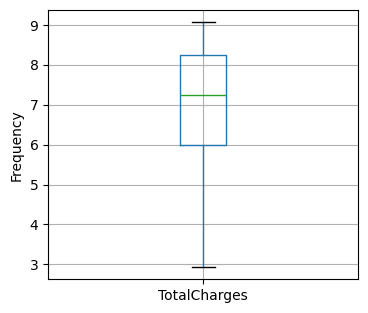

In [418]:
for feature in cont_ft:
   df_copy = df.copy()
   if 0 in df_copy[feature].unique():
      pass
   else:
      df_copy[feature] = np.log(df_copy[feature])
      plt.figure(figsize=(4, 3.5))
      df_copy.boxplot(column = feature)
      plt.ylabel('Frequency')
      plt.show()

In the above boxplots we can see that there are no outliers

#### Categorical Variable and their Cardinality

In [419]:
# we have already filtered out the Categorical features
print(f'{cat_ft}\nCount: {len(cat_ft)}')

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
Count: 17


We have total 17 categorical features

In [420]:
# now let's find out the cardinality of each categorical features
for feature in cat_ft:
   print(f"{feature}: {len(df[feature].unique())}")

gender: 2
Partner: 2
Dependents: 2
PhoneService: 2
MultipleLines: 3
InternetService: 3
OnlineSecurity: 3
OnlineBackup: 3
DeviceProtection: 3
TechSupport: 3
StreamingTV: 3
StreamingMovies: 3
Contract: 3
PaperlessBilling: 2
PaymentMethod: 4
Churn: 2
SeniorCitizen: 2


All the categorical variables have low cardinality which is idea. Maxium cardinality is 4.

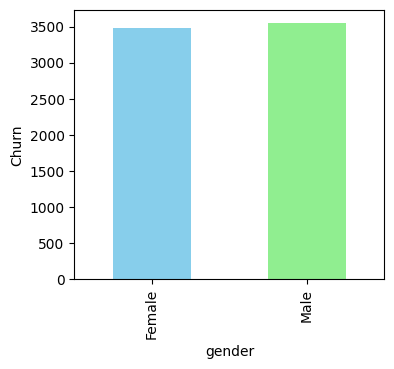

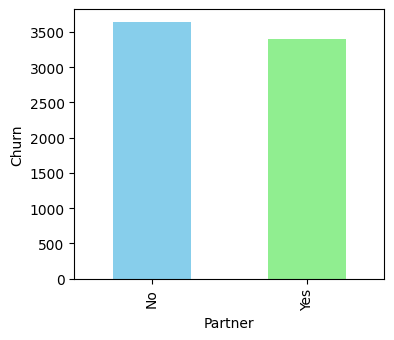

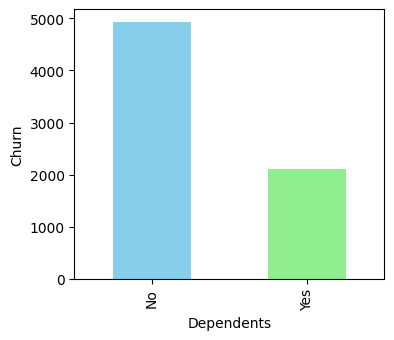

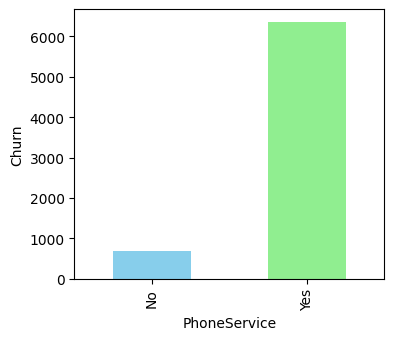

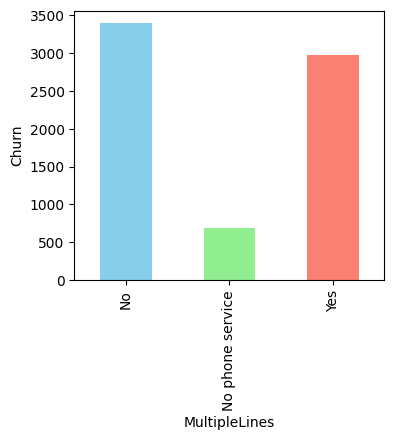

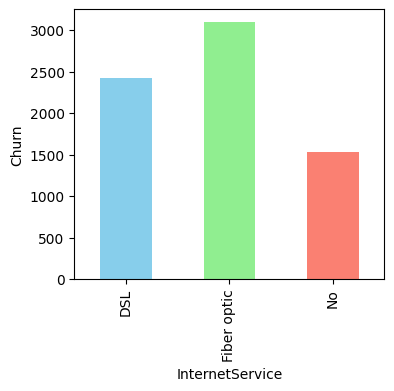

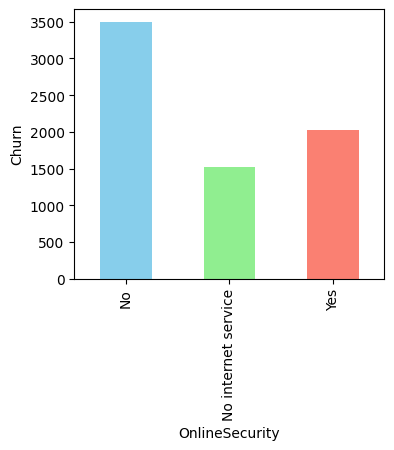

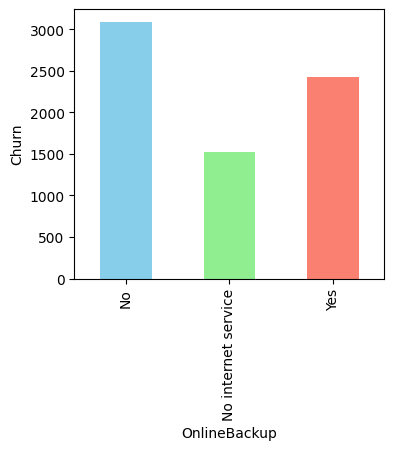

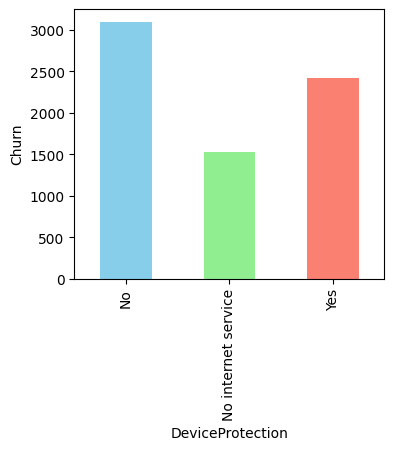

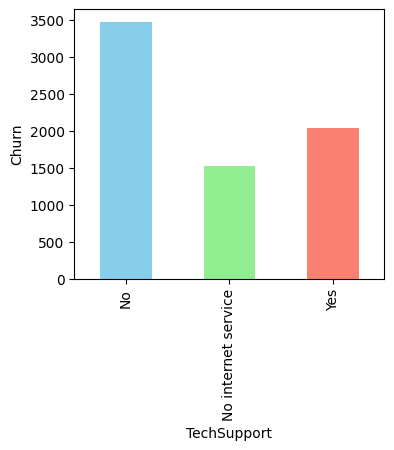

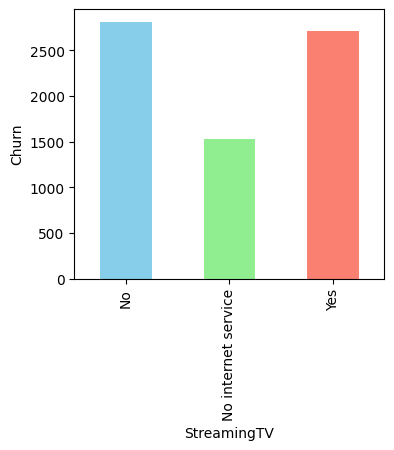

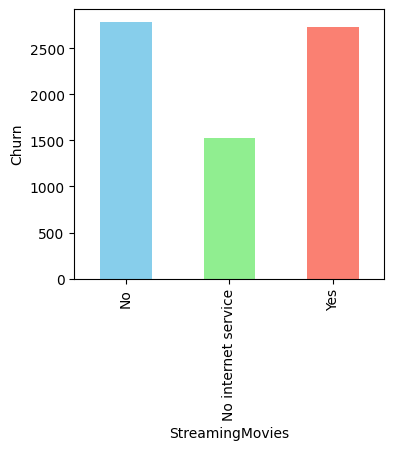

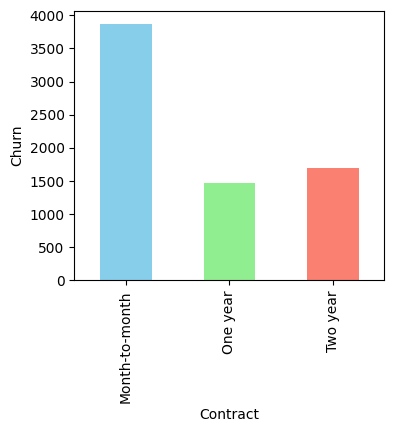

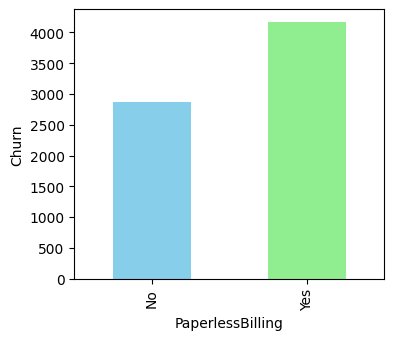

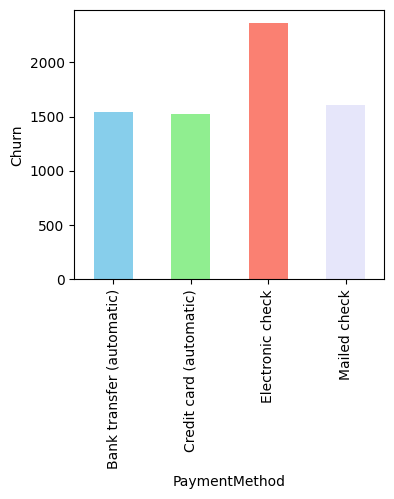

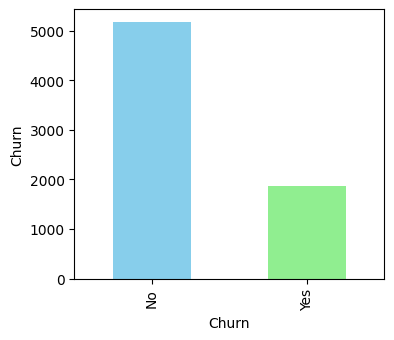

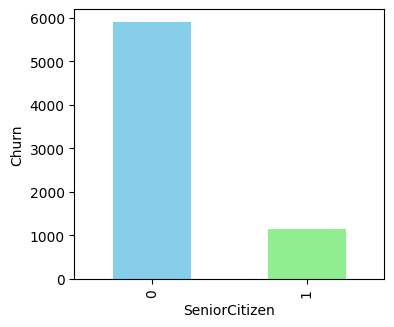

In [422]:
# relation of categorical variable with target variable
for feature in cat_ft:
   df_copy = df.copy()
   plt.figure(figsize=(4, 3.5))
   df_copy.groupby(feature)['Churn'].count().plot.bar(color=['skyblue', 'lightgreen', 'salmon', 'Lavender'])
   plt.ylabel('Churn')
   plt.xlabel(feature)
   plt.show

Using the bar plots we can clearly determine the counts of Churns based on each features

---

## Feature Engineering

In [ ]:
# less than 0.2% data is missing so that we can drop these 

# or else we can simply impute them with median to be safe
median = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median)
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149        4.021917      6.939953
std      24.559481        0.594424      1.551968
min       0.000000        2.904165      2.933857
25%       9.000000        3.569533      5.997011
50%      29.000000        4.253483      7.242422
75%      55.000000        4.498142      8.239224
max      72.000000        4.777020      9.069330


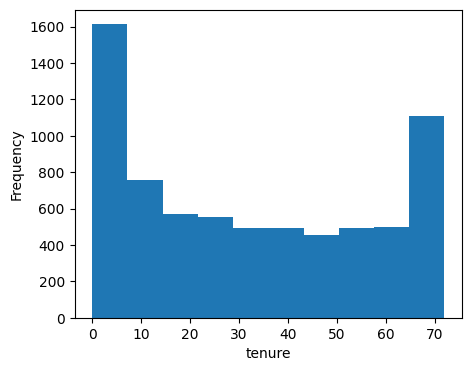

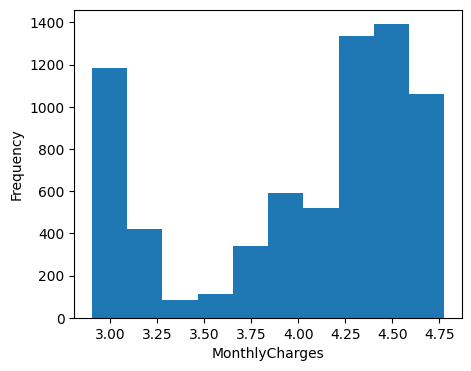

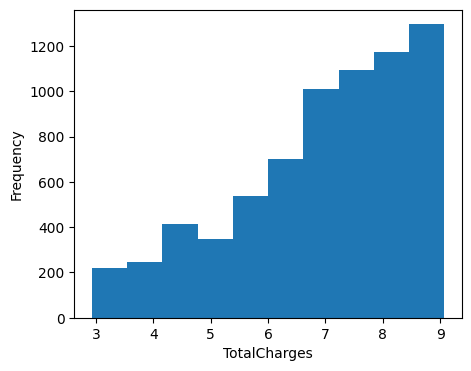

In [ ]:
# normalizing the categorical feature with logarithmic transformation
for feature in cont_ft:
   if 0 in df[feature].unique():
      pass
   else:
      df[feature] = np.log(df[feature])
      

print(df[cont_ft].describe())

for feature in cont_ft:
   plt.figure(figsize=(5, 4))
   plt.hist(df[feature], bins=10)
   plt.xlabel(feature)
   plt.ylabel('Frequency')
   plt.show()

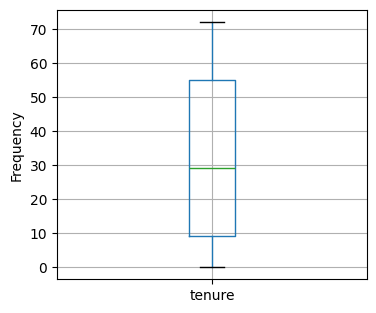

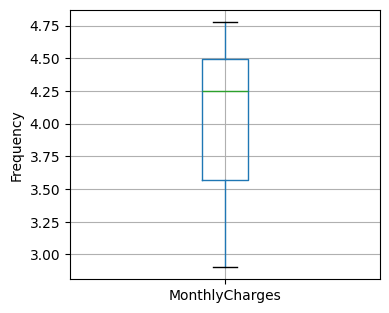

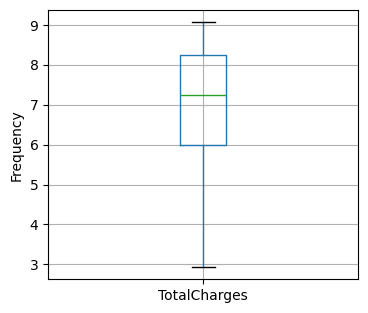

In [ ]:
for feature in cont_ft:
   plt.figure(figsize=(4, 3.5))
   df.boxplot(column = feature)
   plt.ylabel('Frequency')
   plt.show()